# Getting Data and Data Preparation

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
HOUSING_PATH = '/home/centipede/Programs & Projects/California Housing Prices/'
images_path = os.path.join(HOUSING_PATH, "Images")
filename = "california.png"

# Setting style
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


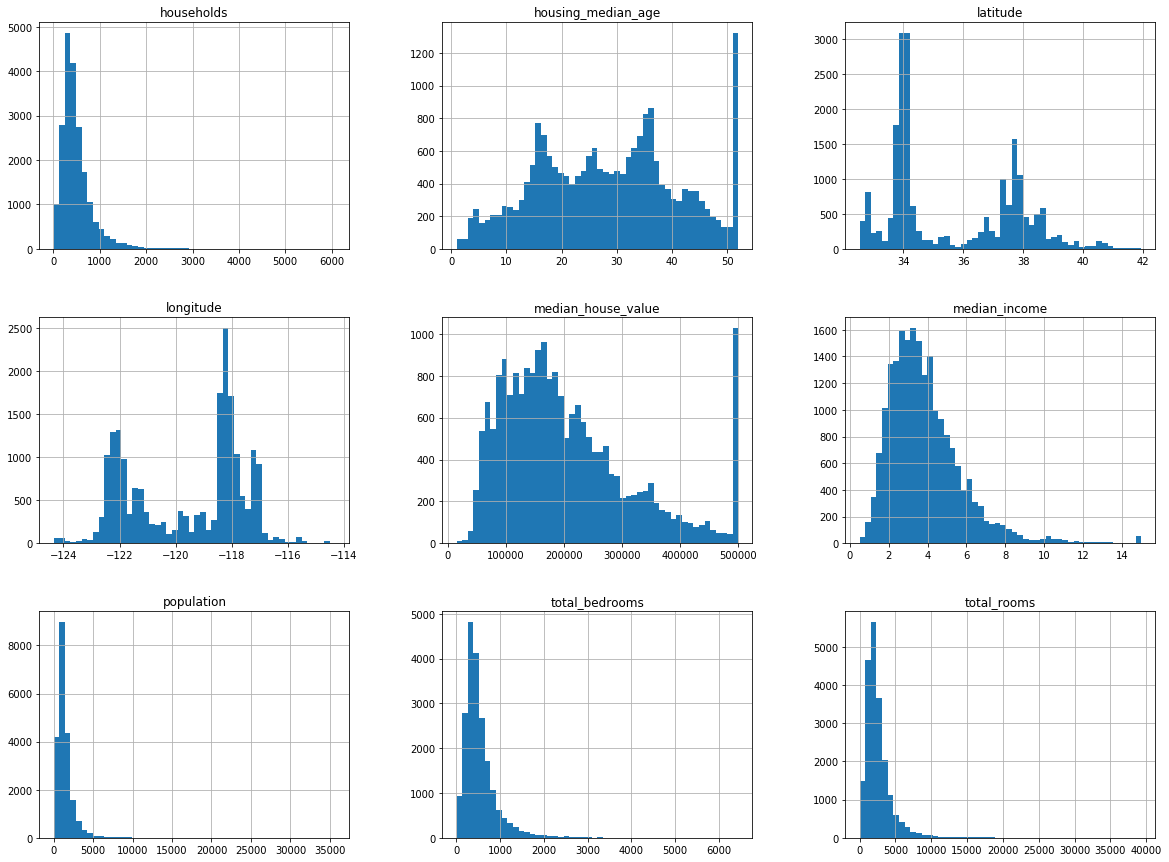

In [9]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)


16512

In [12]:
len(test_set)

4128

>To have a stable train/test split even after updating the dataset, I'll use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier).

>That means we could for example compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset.

>The new test set will contain 20% of the new instances, but it will not contain any
instance that was previously in the training set.

In [13]:
# Add the index column for checking
housing_with_id = housing.reset_index()

In [14]:
# The crc32() function calculates a 32-bit CRC (cyclic redundancy checksum) for a string. 
# This function can be used to validate data integrity

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
# For earlier python version
import hashlib

def test_set_check_2(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [16]:
# Supports any hash function and compatible with all versions of python
def test_set_check_3(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
# To use row index as a unique identifier we have to make sure that the new data gets appended to the end of dataset 
# & "NO ROWS GET DELETED".
# If not possible then we should try to use most stable features to build that unique identifier.

# In this case Use lat and long values which remain stable for a few million years. Hence, combine them into 'ID'

housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [20]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


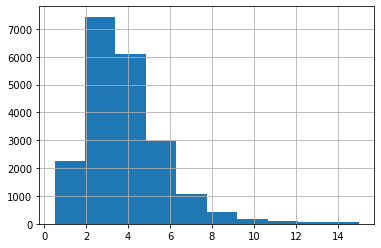

In [21]:
# Given: "median_income" is a very important to predict median housing prices
housing["median_income"].hist()

In [22]:
# Creating "income_cat" column for categories of "median_income" to see if test set is biased or not biased
housing["income_cat"] = pd.cut(housing["median_income"],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[1, 2, 3, 4, 5])

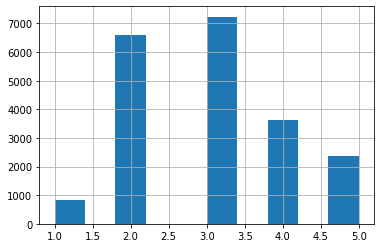

In [23]:
housing["income_cat"].hist()

In [24]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [25]:
# Stratified Sampling: The population is divided into subgroups called "Strata" & then the right number of instances are sampled from each stratum to gurantee that the test set is representative of overall population.

# Startified Sampling on income category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [27]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

_**The test_set generated using stratified sampling has income category proportions almost identical to those in the full dataset,  whereas the test_set generated using purely random sampling is skewed.**_ 

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [29]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


_**Sampling Bias Comparison of Stratified vs Purely Random Sampling**_

In [30]:
# Removing "income_cat" Attribute to get data back to original state
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

# Visualizing Data/ Exploring The Data

In [31]:
housing = strat_train_set.copy()

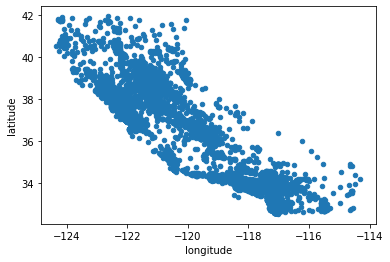

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude")

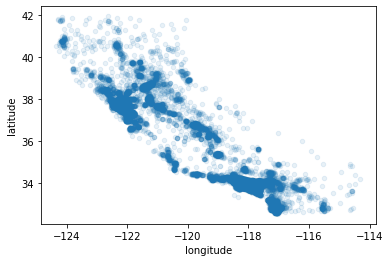

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now we can see the high density areas

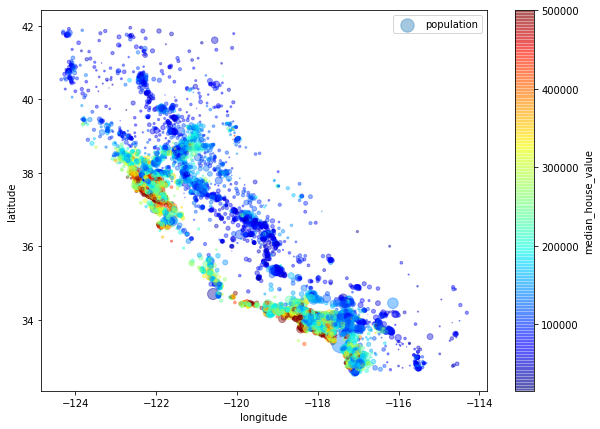

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

* **Radius Of Circle:** Represents the district population(option s)
* **Color:** Represents the price(option c)

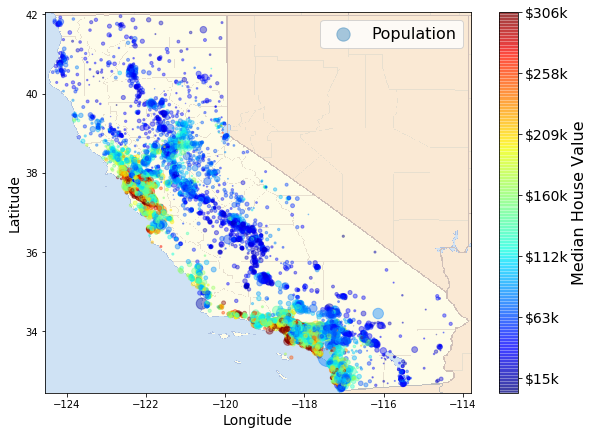

In [36]:
import matplotlib.image as mpimg

california_img=mpimg.imread(os.path.join(images_path, filename))

ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()


In [37]:
# Correlation
corr_matrix = housing.corr()

In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

**From Correlation Values:**
* The median house value tends to go up when the median income goes up

* A small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north)

Another way to check for correlation between attributes throuhgh scatter_matrix()
As there are 11 numerical attribiutes it would give us: 

> **11<sup>2</sup> = 121 plots** 

so I'll focus on a few promising attribiutes that seem most correlated with median housing value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdda8e10190>,
      dtype=object)

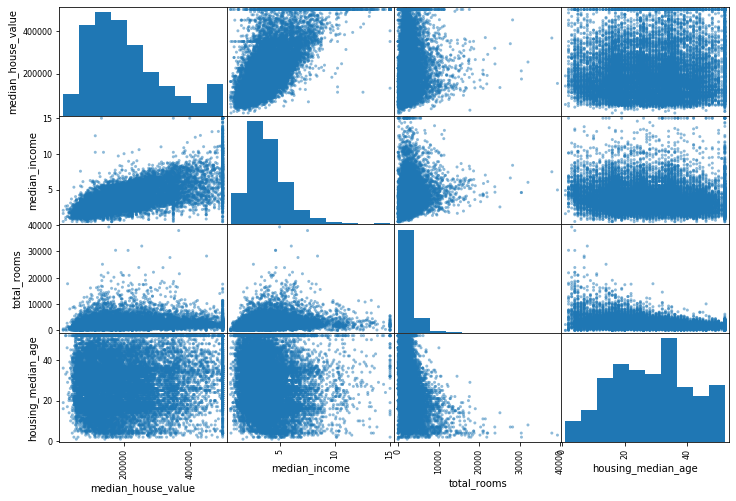

In [39]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


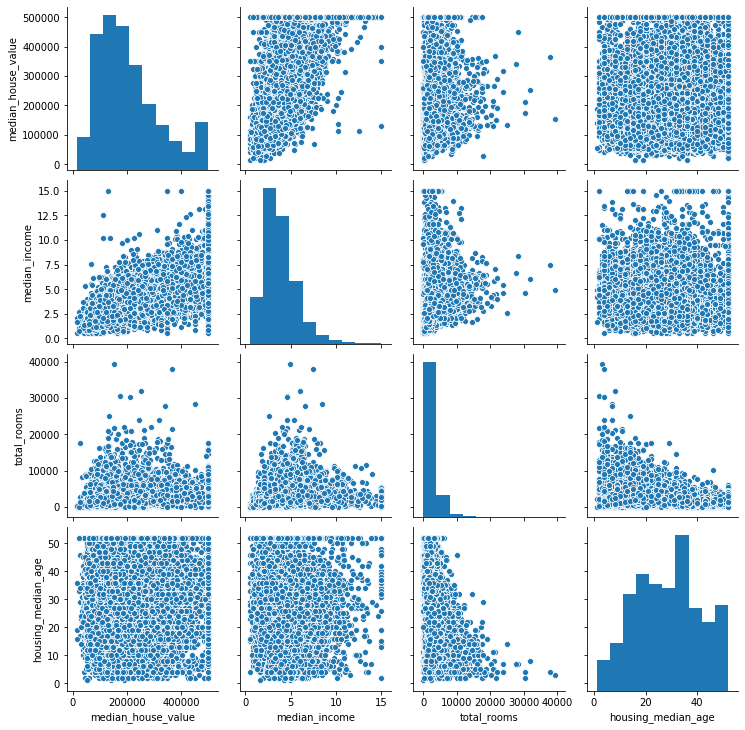

In [40]:
sns.pairplot(housing[attributes])

[0, 16, 0, 550000]

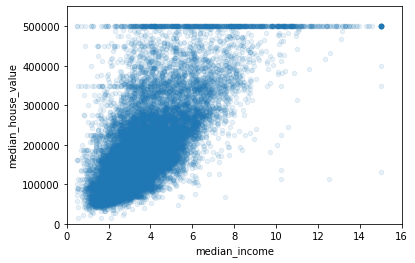

In [41]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])

Observation from plot:
* Strong Correlation present as an upward trend is present and point are not too dispersed.
* Price cap at 500,000
* But st. line also presnet at some other price steps

In [42]:
# Creating new attributes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

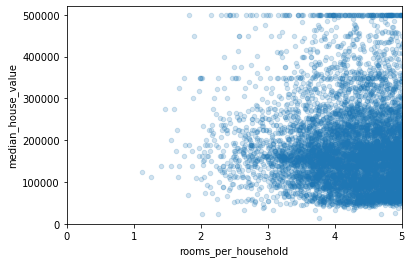

In [43]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [44]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparing our data for the ML Algorithm

In [45]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [46]:
# As "total_bedrooms" has a lot of null values we can either get rid of the corrsponding districts having those 
# null values or get rid of the whole attribute or set its value's to something like 0, median, mean etc.

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [47]:
# BY dropping corrosponding districts
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [48]:
# By dropping attribute
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [49]:
# By replacing with some value(NoteToSelf: Use Sklearn's SimpleImputer for this!!!)
# Replacing by median
median = housing["total_bedrooms"].median()
print("Median For total_bedrooms : ", median)
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

Median For total_bedrooms :  433.0


In [51]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [52]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [53]:
# Removig column "ocean_proximity" which is a the text attribute and median can only be calculated 
# on numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)

In [54]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [55]:
# Imputer calculates the median of each attribute and stores it in its "statistics_" instance variable
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [56]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Vaules are same

In [57]:
# Transforming Training Set
X = imputer.transform(housing_num)

In [58]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [59]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [60]:
imputer.strategy

'median'

In [61]:
# Now handling Categorical Feature
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [62]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [63]:
# List of Categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [64]:
from sklearn.preprocessing import OneHotEncoder
OneHot_encoder = OneHotEncoder()
housing_cat_OneHot = OneHot_encoder.fit_transform(housing_cat)
housing_cat_OneHot

#To convert Sparse matric=x to Numpy Array we sould use either of the folowing
    # housing_cat_1hot.toarray()
# OR
    # cat_encoder = OneHotEncoder(sparse=False)
    # housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
    # housing_cat_1hot



<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [65]:
# Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Columns Indexes
rooms_ix, bedrooms_ix, population_ix, housholds_ix = 3, 4, 5, 6 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, housholds_ix]
        population_per_household = X[:, population_ix] / X[:, housholds_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [66]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"], 
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Pipeline For Preprocessing Numerical Features

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])
# In above all but last estimator must be transformers
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [68]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [69]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [70]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [71]:
print(housing_prepared.shape)

(16512, 16)


In [73]:
# Another way to do the above
from sklearn.base import BaseEstimator, TransformerMixin

# Created a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [74]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Selecting And Training The Model

In [75]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
# Trying it out on some data
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prep = full_pipeline.transform(some_data)

In [77]:
print("Predictions: ", lin_reg.predict(some_data_prep))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [78]:
# Actuals
print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print("RMSE: ", lin_rmse)
print("MAE: ", lin_mae)

RMSE:  68628.19819848923
MAE:  49439.89599001897


Most districts "median_housing_values" range between 120000 to 265000 dollars but with the errror of around
l8628 dollars is not good.
Here The model is **Underfitted**

In [80]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_mae = mean_absolute_error(housing_labels, housing_predictions)

print("RMSE: ", tree_rmse)
print("MAE: ", tree_mae)

RMSE:  0.0
MAE:  0.0


Now its a case of **OverFitting**

# Fine Tuning the model

In [81]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [70243.92172296 66117.76437834 72552.19221492 70254.10266427
 70665.47893466 76264.36977751 70233.61439046 71638.87686119
 76150.78844889 69683.2411276 ]
Mean: 71380.43505208121
Standard deviation: 2881.175348056567


In [83]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


In [84]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [85]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [86]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [87]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [88]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [89]:
# Applying GridSearch to find best combination of hyperparameter values
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error", 
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [90]:
print("The best hyperparameter combination: ", grid_search.best_params_)

The best hyperparameter combination:  {'max_features': 8, 'n_estimators': 30}


In [91]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [93]:
# Scoring of each hyperparameter combination tested during the grid search

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64691.52257809957 {'max_features': 2, 'n_estimators': 3}
55855.43789749447 {'max_features': 2, 'n_estimators': 10}
53033.73627119299 {'max_features': 2, 'n_estimators': 30}
60123.32401313755 {'max_features': 4, 'n_estimators': 3}
53088.49226011194 {'max_features': 4, 'n_estimators': 10}
50699.418180084314 {'max_features': 4, 'n_estimators': 30}
58663.25841597268 {'max_features': 6, 'n_estimators': 3}
52309.99012377737 {'max_features': 6, 'n_estimators': 10}
50233.70012227607 {'max_features': 6, 'n_estimators': 30}
59703.57434356319 {'max_features': 8, 'n_estimators': 3}
52282.71576433476 {'max_features': 8, 'n_estimators': 10}
50080.638866386544 {'max_features': 8, 'n_estimators': 30}
63368.3329510451 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54255.84297918773 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59258.77040606529 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52810.86397921729 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

from the above we can see that we get the best solution when we set the following values for the hyperparameters:

* max_features = 8
* n_estimators = 30

wihch results in an rmse score of 50080 which is slightly better than the scoreswhcih we got with default parameters

In [94]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.066181,0.013806,0.003470,0.000247,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.992873e+09,-4.287910e+09,...,-4.184993e+09,1.655730e+08,18,-1.133076e+09,-9.943088e+08,-1.115191e+09,-1.209249e+09,-1.056517e+09,-1.101668e+09,7.253624e+07
1,0.193976,0.003157,0.009388,0.000345,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.881154e+09,-3.288192e+09,...,-3.119830e+09,1.637366e+08,11,-5.682437e+08,-5.672303e+08,-5.544404e+08,-5.800013e+08,-5.543134e+08,-5.648458e+08,9.655291e+06
2,0.576264,0.007034,0.026549,0.000699,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.654913e+09,-2.935784e+09,...,-2.812577e+09,1.508437e+08,8,-4.461893e+08,-4.306581e+08,-4.220576e+08,-4.351470e+08,-4.273446e+08,-4.322793e+08,8.163017e+06
3,0.098341,0.002731,0.003351,0.000026,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.503453e+09,-3.646317e+09,...,-3.614814e+09,1.221424e+08,16,-9.971130e+08,-9.426745e+08,-9.608264e+08,-8.900451e+08,-9.448375e+08,-9.470993e+08,3.455335e+07
4,0.317695,0.003610,0.009147,0.000053,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.779629e+09,-2.759407e+09,...,-2.818388e+09,7.838363e+07,9,-5.400735e+08,-5.029884e+08,-5.086818e+08,-5.277669e+08,-5.252480e+08,-5.209517e+08,1.344455e+07
5,0.951148,0.004704,0.025564,0.000108,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.453939e+09,-2.640557e+09,...,-2.570431e+09,1.089814e+08,3,-3.879789e+08,-3.928065e+08,-3.862053e+08,-4.112021e+08,-3.816986e+08,-3.919783e+08,1.024922e+07
6,0.134261,0.003814,0.003381,0.000024,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.109520e+09,-3.395411e+09,...,-3.441378e+09,2.040027e+08,13,-8.878291e+08,-9.592715e+08,-8.990000e+08,-9.263405e+08,-8.683765e+08,-9.081635e+08,3.169510e+07
7,0.445414,0.004090,0.009163,0.000045,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.533512e+09,-2.768410e+09,...,-2.736335e+09,1.639703e+08,6,-5.135719e+08,-4.955771e+08,-5.098043e+08,-5.004204e+08,-5.154313e+08,-5.069610e+08,7.692946e+06
8,1.339193,0.018774,0.025674,0.000222,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.351232e+09,-2.581478e+09,...,-2.523425e+09,1.415576e+08,2,-3.890172e+08,-3.740782e+08,-3.795418e+08,-3.967770e+08,-3.812657e+08,-3.841360e+08,7.926207e+06
9,0.175395,0.002095,0.003352,0.000037,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.065216e+09,-3.721052e+09,...,-3.564517e+09,2.968629e+08,15,-8.516081e+08,-9.510450e+08,-9.216145e+08,-9.874909e+08,-8.972617e+08,-9.218040e+08,4.625932e+07


When to use which:
* If the number of combination in hyperparameter search is small we can use GridSearchCV()
* If the number of combination in hyperparameter search is large then use RandomizedSearchCV()

In [95]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=200)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, 
                                n_iter=10, cv=5, scoring="neg_mean_squared_error", 
                                random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [97]:
# Score of each hyperparameter combination tested during the randomized search

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49083.13003074753 {'max_features': 7, 'n_estimators': 180}
50724.55401009645 {'max_features': 5, 'n_estimators': 15}
50656.835090376044 {'max_features': 3, 'n_estimators': 72}
50156.90724510428 {'max_features': 5, 'n_estimators': 21}
49210.95546284717 {'max_features': 7, 'n_estimators': 122}
50611.98734081449 {'max_features': 3, 'n_estimators': 75}
50553.834106272756 {'max_features': 3, 'n_estimators': 88}
49197.57557852257 {'max_features': 5, 'n_estimators': 100}
50389.91073816241 {'max_features': 3, 'n_estimators': 150}
64253.527385000976 {'max_features': 5, 'n_estimators': 2}


In [98]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=200, verbose=0, warm_start=False)

In [99]:
pd.DataFrame(rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.545701,0.103979,0.155049,0.007006,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.259465e+09,-2.461003e+09,-2.546424e+09,-2.253037e+09,-2.525839e+09,-2.409154e+09,1.280047e+08,1
1,0.571760,0.002274,0.014158,0.000575,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.454376e+09,-2.655601e+09,-2.659061e+09,-2.398345e+09,-2.697519e+09,-2.572980e+09,1.219102e+08,9
2,1.854626,0.025161,0.061224,0.001259,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.423029e+09,-2.646005e+09,-2.686510e+09,-2.403881e+09,-2.671149e+09,-2.566115e+09,1.254614e+08,8
3,0.802641,0.010025,0.019044,0.001019,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.367079e+09,-2.610320e+09,-2.602763e+09,-2.357295e+09,-2.641120e+09,-2.515715e+09,1.260506e+08,4
4,6.337031,0.137852,0.103600,0.001487,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.272998e+09,-2.489095e+09,-2.556421e+09,-2.274632e+09,-2.515445e+09,-2.421718e+09,1.226552e+08,3
5,1.939222,0.028141,0.063511,0.000787,3,75,"{'max_features': 3, 'n_estimators': 75}",-2.409409e+09,-2.641102e+09,-2.680277e+09,-2.407934e+09,-2.669144e+09,-2.561573e+09,1.254957e+08,7
6,2.321665,0.077923,0.078645,0.005656,3,88,"{'max_features': 3, 'n_estimators': 88}",-2.405252e+09,-2.633437e+09,-2.679372e+09,-2.396801e+09,-2.663589e+09,-2.555690e+09,1.271702e+08,6
7,3.899044,0.028976,0.083639,0.000486,5,100,"{'max_features': 5, 'n_estimators': 100}",-2.275263e+09,-2.480978e+09,-2.542970e+09,-2.255080e+09,-2.547717e+09,-2.420401e+09,1.290721e+08,2
8,3.915187,0.022489,0.128371,0.004006,3,150,"{'max_features': 3, 'n_estimators': 150}",-2.383917e+09,-2.608099e+09,-2.673574e+09,-2.377657e+09,-2.652469e+09,-2.539143e+09,1.310285e+08,5
9,0.080060,0.001457,0.002584,0.000111,5,2,"{'max_features': 5, 'n_estimators': 2}",-4.090697e+09,-4.243337e+09,-4.349475e+09,-3.702394e+09,-4.256675e+09,-4.128516e+09,2.286663e+08,10


In [100]:
grid_feature_importances = grid_search.best_estimator_.feature_importances_
grid_feature_importances

array([7.57664244e-02, 6.40056591e-02, 4.11916134e-02, 1.57445792e-02,
       1.46342146e-02, 1.46344135e-02, 1.41384562e-02, 3.35049697e-01,
       6.04630614e-02, 1.06655271e-01, 6.94347353e-02, 9.52177643e-03,
       1.71252707e-01, 9.80170062e-05, 2.31314283e-03, 5.09623219e-03])

In [101]:
rnd_feature_importances = rnd_search.best_estimator_.feature_importances_
rnd_feature_importances

array([7.19382389e-02, 6.52331055e-02, 4.26835209e-02, 1.66753713e-02,
       1.57156422e-02, 1.64086635e-02, 1.56025282e-02, 3.51440630e-01,
       5.58770864e-02, 1.10148205e-01, 6.92147761e-02, 9.59924389e-03,
       1.52049693e-01, 7.99192941e-05, 3.24231115e-03, 4.09106488e-03])

### Displaying the importance scores next to their corrosponding attribute names

In [102]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [103]:
sorted(zip(grid_feature_importances, attributes), reverse=True)

[(0.33504969714739913, 'median_income'),
 (0.17125270672314957, 'INLAND'),
 (0.1066552705301511, 'pop_per_hhold'),
 (0.07576642441147459, 'longitude'),
 (0.0694347352795788, 'bedrooms_per_room'),
 (0.0640056591147412, 'latitude'),
 (0.060463061441338034, 'rooms_per_hhold'),
 (0.0411916133977688, 'housing_median_age'),
 (0.01574457920355112, 'total_rooms'),
 (0.014634413460211654, 'population'),
 (0.014634214578962896, 'total_bedrooms'),
 (0.014138456247258607, 'households'),
 (0.009521776431262126, '<1H OCEAN'),
 (0.00509623219403971, 'NEAR OCEAN'),
 (0.0023131428329108, 'NEAR BAY'),
 (9.801700620194276e-05, 'ISLAND')]

In [104]:
sorted(zip(rnd_feature_importances, attributes), reverse=True)

[(0.35144063046411805, 'median_income'),
 (0.15204969264807192, 'INLAND'),
 (0.11014820467392095, 'pop_per_hhold'),
 (0.07193823886125224, 'longitude'),
 (0.06921477612742863, 'bedrooms_per_room'),
 (0.06523310545409004, 'latitude'),
 (0.055877086411575, 'rooms_per_hhold'),
 (0.04268352091038976, 'housing_median_age'),
 (0.01667537129390275, 'total_rooms'),
 (0.016408663543247368, 'population'),
 (0.01571564219275444, 'total_bedrooms'),
 (0.015602528201084332, 'households'),
 (0.009599243891555153, '<1H OCEAN'),
 (0.004091064880333557, 'NEAR OCEAN'),
 (0.0032423111521406043, 'NEAR BAY'),
 (7.991929413533644e-05, 'ISLAND')]

### Evaluating on Test Set

In [107]:
final_model_gridsearch = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions_gridsearch = final_model_gridsearch.predict(X_test_prepared)

final_mse_gridsearch = mean_squared_error(y_test, final_predictions_gridsearch)
final_rmse_gridsearch = np.sqrt(final_mse_gridsearch)

final_rmse_gridsearch

47955.88381473155

In [108]:
final_model_rndsearch = rnd_search.best_estimator_

final_predictions_rndsearch = final_model_rndsearch.predict(X_test_prepared)

final_mse_rndsearch = mean_squared_error(y_test, final_predictions_rndsearch)
final_rmse_rndsearch = np.sqrt(final_mse_rndsearch)

final_rmse_rndsearch

47083.33880602618

**We can compute a 95% confidence interval for the test RMSE:**

In [109]:
from scipy import stats
confidence = 0.95

squared_errors_grid = (final_predictions_gridsearch - y_test) ** 2

squared_errors_rnd = (final_predictions_rndsearch - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors_grid)-1,
                        loc=squared_errors_grid.mean(),
                        scale=stats.sem(squared_errors_grid)))

array([45878.46796191, 49946.96950139])

In [110]:
np.sqrt(stats.t.interval(confidence, len(squared_errors_rnd)-1,
                        loc=squared_errors_rnd.mean(),
                        scale=stats.sem(squared_errors_rnd)))

array([45107.88338476, 48979.18377018])

In [112]:
# Computing Manually
m = len(squared_errors_grid)
mean_grid = squared_errors_grid.mean()
tscore_grid = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin_grid = tscore_grid * squared_errors_grid.std(ddof=1) / np.sqrt(m)
np.sqrt(mean_grid - tmargin_grid), np.sqrt(mean_grid + tmargin_grid)

(45878.46796190589, 49946.96950138654)

In [113]:
m2 = len(squared_errors_rnd)
mean_rnd = squared_errors_rnd.mean()
tscore_rnd = stats.t.ppf((1 + confidence) / 2, df=m2 - 1)
tmargin_rnd = tscore_rnd * squared_errors_rnd.std(ddof=1) / np.sqrt(m2)
np.sqrt(mean_rnd - tmargin_rnd), np.sqrt(mean_rnd + tmargin_rnd)

(45107.88338475783, 48979.183770181284)

In [114]:
# To use Z Scores

zscore_grid = stats.norm.ppf((1 + confidence) / 2)
zmargin_grid = zscore_grid * squared_errors_grid.std(ddof=1) / np.sqrt(m)
np.sqrt(mean_grid - zmargin_grid), np.sqrt(mean_grid + zmargin_grid)

(45879.09101212937, 49946.397195441554)

In [115]:
zscore_rnd = stats.norm.ppf((1 + confidence) / 2)
zmargin_rnd = zscore_rnd * squared_errors_rnd.std(ddof=1) / np.sqrt(m2)
np.sqrt(mean_rnd - zmargin_rnd), np.sqrt(mean_rnd + zmargin_rnd)

(45108.47542485274, 48978.6385181495)

## Extra Functions

In [117]:
# Pipeline with both Preparation and Predictor
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("linear", LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [118]:
## Saving and loading model
my_model = full_pipeline_with_predictor

In [119]:
import joblib
joblib.dump(my_model, "/home/centipede/Programs & Projects/California Housing Prices/Model/my_model.pkl")
my_model_loaded = joblib.load("/home/centipede/Programs & Projects/California Housing Prices/Model/my_model.pkl")

## Scipy Distribution For RandomizedSearchCV

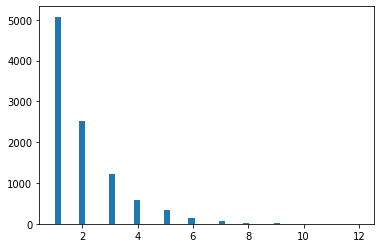

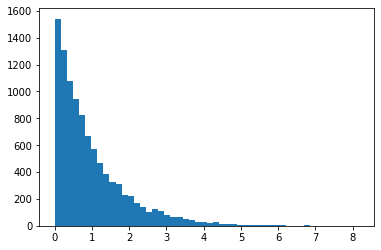

In [122]:
from scipy.stats import geom, expon

geom_distrib = geom(0.5).rvs(10000, random_state=42)
expon_distrib = expon(scale=1).rvs(10000, random_state=42)

plt.hist(geom_distrib, bins=50)
plt.show()

plt.hist(expon_distrib, bins=50)
plt.show()